# Training Model with Beeldmaterial (5m) Orthophotos: Adjusting Patch Size

In [1]:
import os
import random
import rasterio
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np
from contextlib import nullcontext

import torch
import torch.nn as nn
import torch.nn.functional as F
from rasterio.windows import Window
from rasterio.windows import bounds as win_bounds
from rasterio.windows import from_bounds as win_from_bounds
from rasterio.coords import BoundingBox
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

## Data Loading

In [2]:
train_rgb  = Path("../data/train_rgb")
test_rgb   = Path("../data/test_rgb")
train_ndvi = Path("../data/train_ndvi")
test_ndvi  = Path("../data/test_ndvi")

train_rgb_tiles  = sorted([p.name for p in train_rgb.glob("*.tif")])
test_rgb_tiles   = sorted([p.name for p in test_rgb.glob("*.tif")])
train_ndvi_tiles = sorted([p.name for p in train_ndvi.glob("*.tif")])
test_ndvi_tiles  = sorted([p.name for p in test_ndvi.glob("*.tif")])

## patch_size = 128

### Model Creation

In [3]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 128,
    "stride": None,
    "num_epochs": 1,
    "ignore_index": 255,
    "num_classes": 3,

    # Model capacity
    "unet_depth": 4,
    "base_filters": 32,
    "use_batchnorm": True,
    "dropout_p": 0.0,

    # Optimizer / LR
    "optimizer": "adamw",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,

    # Loss & class imbalance
    "loss_type": "ce",
    "dice_alpha": 0.5,
    "focal_gamma": 2.0,
    "class_weights": "inv",
    "precomputed_counts": None,

    # Training tricks
    "accum_steps": 4,
    "use_amp": True,

    # Augmentations (applied per patch)
    "aug_strength": "none",

    # >>> NEW <<<
    "use_ndvi": True,              # set False to go RGB-only
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    # Accept None | np.ndarray | torch.Tensor
    if isinstance(class_weights, torch.Tensor):
        weight = class_weights  # already on device (ideally)
    elif class_weights is None:
        weight = None
    else:
        weight = torch.tensor(class_weights, dtype=torch.float32)  # CPU for now

    if loss_type == "ce":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        # ensure weight follows logits device at call time
        def ce_wrap(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return ce(logits, target)
        return ce_wrap

    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed

    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=weight)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")


# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    if strength == "none":
        return img_chw, lab_hw

    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1].copy()
        lab_hw  = lab_hw[:, ::-1].copy()
    if do_v:
        img_chw = img_chw[:, ::-1, :].copy()
        lab_hw  = lab_hw[::-1, :].copy()
    if krot:
        img_chw = np.rot90(img_chw, krot, axes=(-2,-1)).copy()
        lab_hw  = np.rot90(lab_hw,  krot, axes=(-2,-1)).copy()

    # final safety (ensures positive strides & contiguous)
    return np.ascontiguousarray(img_chw), np.ascontiguousarray(lab_hw)


# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    """
    img_hwcn: float32 array (H, W, C). May contain NaN in some channels (e.g., NDVI).
    We compute per-channel mean/std ignoring NaNs.
    """
    img = img_hwcn.astype(np.float32, copy=False)

    # Compute per-channel stats ignoring NaNs
    mean = np.nanmean(img, axis=(0, 1))
    std  = np.nanstd(img,  axis=(0, 1)) + 1e-6

    # Normalise where finite; keep NaNs for now
    img = (img - mean) / std

    # Replace any remaining non-finite with 0 (safe neutral value)
    img[~np.isfinite(img)] = 0.0

    # CHW tensor, contiguous float32
    return np.transpose(img, (2, 0, 1)).astype(np.float32, copy=False).copy()


### Training

In [4]:
rgb_folder_path     = Path("../data/train_rgb")                 # e.g. ../data/5m_rgb
ndvi_folder_path    = Path("../data/train_ndvi")             # NDVI tiles with ..._CIR_lrl.tif
label_train_folder  = Path("../data/lulc_tiles_train")

assert isinstance(train_rgb_tiles, list) and len(train_rgb_tiles) > 0, "train_rgb_tiles is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":
        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_rgb_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Helper: map RGB filename -> NDVI filename ----------
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    # fallback (case-insensitive)
    stem, ext = Path(rgb_name).stem, Path(rgb_name).suffix
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# (Optional) If you already have mapping dicts from your split step, you can use them:
# ndvi_by_rgb_train = {rgb: ndvi for rgb, ndvi in zip(train_rgb_tiles, train_ndvi_tiles)}  # if available

# ---------- Build model, optimizer, loss ----------
in_channels = 4 if CFG["use_ndvi"] else 3
model = UNetFlex(
    in_ch=in_channels,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# after you compute class_weights_vec
if class_weights_vec is not None:
    class_weights_t = torch.tensor(class_weights_vec, dtype=torch.float32, device=DEVICE)
else:
    class_weights_t = None

criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_t,   # pass a TENSOR already on DEVICE
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_rgb_tiles, start=1):
    print(f"{idx}/{len(train_rgb_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    # Resolve NDVI path if used
    if CFG["use_ndvi"]:
        # If you have ndvi_by_rgb_train dict, use: ndvi_name = ndvi_by_rgb_train.get(fname)
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping.")
            continue

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if CFG["use_ndvi"] else nullcontext(None)) as ndvi_src:

        # Grid checks (labels vs RGB)
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # read label once (RAM)
        label_full = lab_src.read(1)

        # Prepare NDVI reader aligned to RGB (only if used)
        if CFG["use_ndvi"]:
            need_vrt = (ndvi_src.crs != rgb_src.crs) or (ndvi_src.transform != rgb_src.transform) \
                       or (ndvi_src.width != rgb_src.width) or (ndvi_src.height != rgb_src.height)
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,  # continuous
                )
            else:
                ndvi_reader = ndvi_src

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch ----
                rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)  # (3,h,w)

               # ---- NDVI patch (optional) ----
                if CFG["use_ndvi"]:
                    # Read as masked to respect input nodata; keep as float32
                    ndvi_ma = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)  # MaskedArray (h, w)
                    ndvi_data = ndvi_ma.filled(np.nan)  # nodata -> NaN
                    # NDVI should live in [-1, 1]; clip outliers
                    ndvi_data = np.clip(ndvi_data, -1.0, 1.0)

                    # Stack with RGB
                    # (RGB comes as uint16; cast to float before stacking)
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)  # (3,h,w)
                    ndvi_patch = ndvi_data[np.newaxis, ...]  # (1,h,w)
                    img_patch = np.concatenate([rgb_patch, ndvi_patch], axis=0)  # (4,h,w)
                    img_hwcn  = np.transpose(img_patch, (1, 2, 0))               # (h,w,4)
                else:
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)
                    img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))               # (h,w,3)


                img_chw = normalize_img(img_hwcn)  # (C,H,W) where C = 3 or 4

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        if CFG["use_ndvi"] and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

Computing class counts for weights...
Class counts (1..C): [1556645, 2189268, 1117898]
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


### Testing

In [5]:
rgb_folder_path   = Path("../data/test_rgb")
ndvi_folder_path  = Path("../data/test_ndvi")
label_test_folder = Path("../data/lulc_tiles_test")

assert isinstance(test_rgb_tiles, list) and len(test_rgb_tiles) > 0, "test_rgb_tiles list is empty or undefined."
model.eval()

# --- Global confusion matrix ---
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

# --- Helper: map RGB → NDVI filename ---
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem = Path(rgb_name).stem
    ext  = Path(rgb_name).suffix
    i = stem.lower().find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# --- Tile evaluation ---
@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    # NDVI
    use_ndvi = bool(CFG.get("use_ndvi", False))
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping tile.")
            return

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if use_ndvi else nullcontext(None)) as ndvi_src:

        # --- Grid checks ---
        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata
        label_full = lab_src.read(1)

        # --- Align NDVI if needed ---
        if use_ndvi:
            need_vrt = (
                ndvi_src.crs != rgb_src.crs or
                ndvi_src.transform != rgb_src.transform or
                ndvi_src.width != rgb_src.width or
                ndvi_src.height != rgb_src.height
            )
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                )
            else:
                ndvi_reader = ndvi_src

        # --- Slide over patches ---
        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)

            # NDVI patch
            if use_ndvi:
                ndvi_ma   = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)
                ndvi_data = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)
                ndvi_ch   = ndvi_data[np.newaxis, ...]
                img_patch = np.concatenate([rgb_patch, ndvi_ch], axis=0)   # (4,h,w)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))             # (h,w,4)
            else:
                img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))             # (h,w,3)

            # Normalise
            img_chw = normalize_img(img_hwcn)

            # Label patch
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Confusion matrix update
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)

        if use_ndvi and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

# --- Run evaluation ---
total_tiles = len(test_rgb_tiles)
for i, fname in enumerate(test_rgb_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# --- Compute metrics ---
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE (RGB{}NDVI) ===".format("+" if CFG["use_ndvi"] else " "))
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 2/6: 2025_250000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 4/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 6/6: 2025_262000_470000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE (RGB+NDVI) ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.5761
Mean Accuracy (mAcc):  0.5569
Mean IoU (mIoU):       0.3802
Mean F1:               0.5415

Per-class results:
  Farms (1)        Precision: 0.7294  Recall: 0.6749  IoU: 0.5398  F1: 0.7011
  Other veg (2)    Precision: 0.5120  Recall: 0.4567  IoU: 0.3182  F1: 0.4828
  All others (3)   Precision: 0.3724  Recall: 0.5392  IoU: 0.2825  F1: 0.4405

Confusion Matrix (rows=true, cols=pred):
[[805134 284453 103319]
 [201500 393229 266325]
 [ 97188  90281 219324]]


### Performance Metrics (Plots)

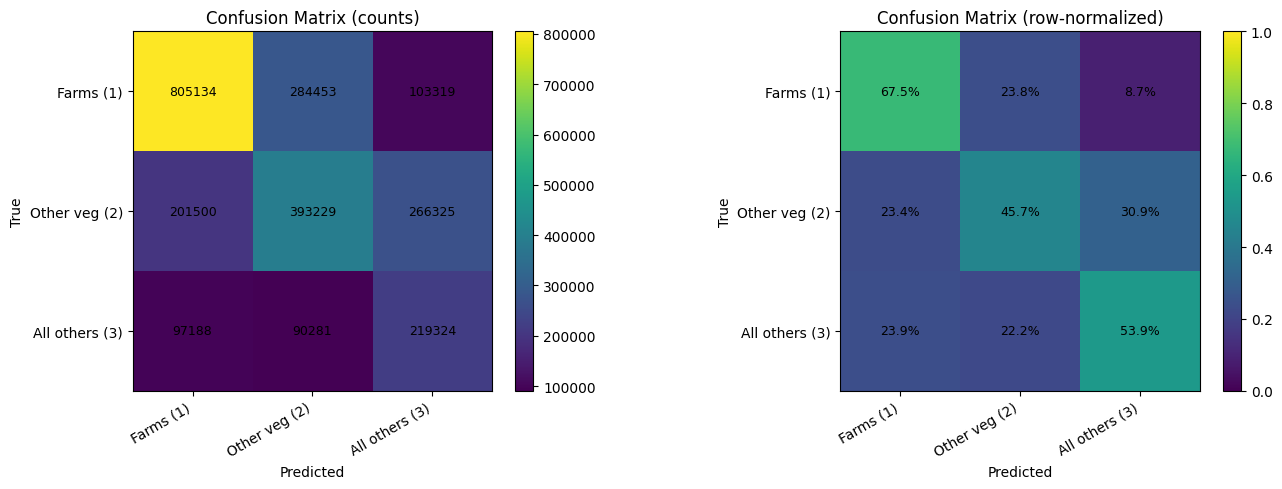

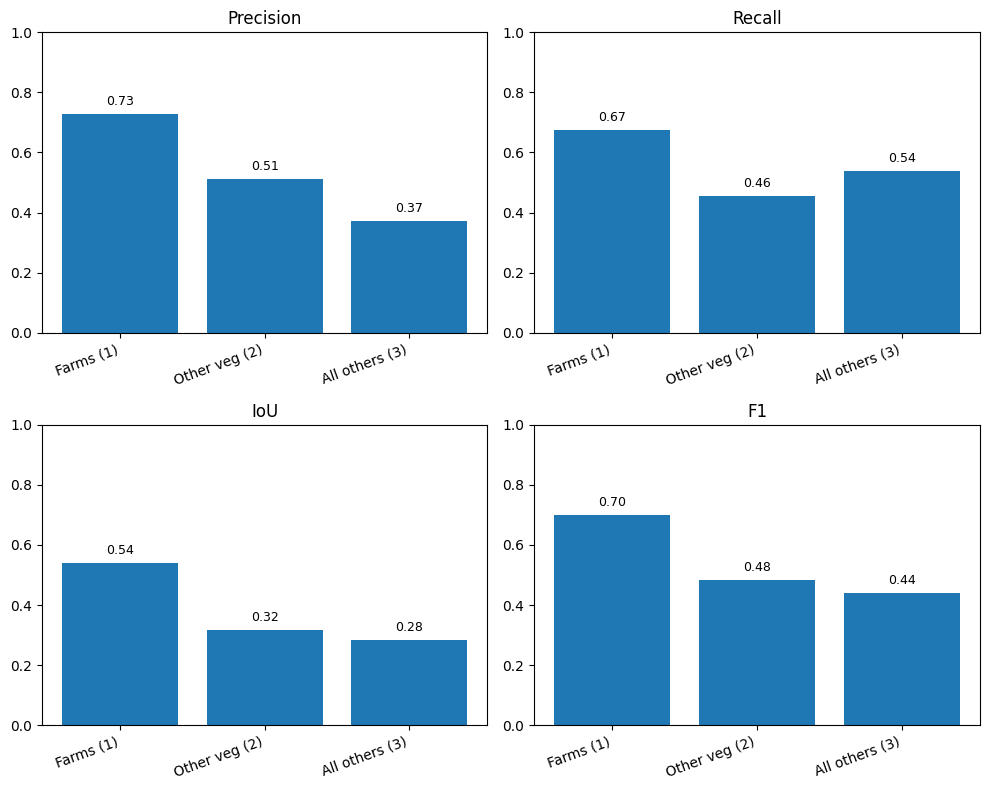

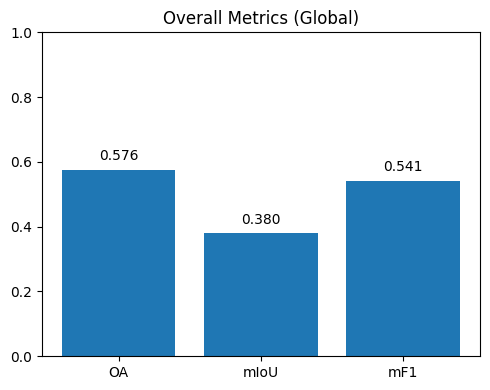

In [6]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

## patch_size = 256

### Model Creation

In [7]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 256,
    "stride": None,
    "num_epochs": 1,
    "ignore_index": 255,
    "num_classes": 3,

    # Model capacity
    "unet_depth": 4,
    "base_filters": 32,
    "use_batchnorm": True,
    "dropout_p": 0.0,

    # Optimizer / LR
    "optimizer": "adamw",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,

    # Loss & class imbalance
    "loss_type": "ce",
    "dice_alpha": 0.5,
    "focal_gamma": 2.0,
    "class_weights": "inv",
    "precomputed_counts": None,

    # Training tricks
    "accum_steps": 4,
    "use_amp": True,

    # Augmentations (applied per patch)
    "aug_strength": "none",

    # >>> NEW <<<
    "use_ndvi": True,              # set False to go RGB-only
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    # Accept None | np.ndarray | torch.Tensor
    if isinstance(class_weights, torch.Tensor):
        weight = class_weights  # already on device (ideally)
    elif class_weights is None:
        weight = None
    else:
        weight = torch.tensor(class_weights, dtype=torch.float32)  # CPU for now

    if loss_type == "ce":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        # ensure weight follows logits device at call time
        def ce_wrap(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return ce(logits, target)
        return ce_wrap

    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed

    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=weight)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")


# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    if strength == "none":
        return img_chw, lab_hw

    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1].copy()
        lab_hw  = lab_hw[:, ::-1].copy()
    if do_v:
        img_chw = img_chw[:, ::-1, :].copy()
        lab_hw  = lab_hw[::-1, :].copy()
    if krot:
        img_chw = np.rot90(img_chw, krot, axes=(-2,-1)).copy()
        lab_hw  = np.rot90(lab_hw,  krot, axes=(-2,-1)).copy()

    # final safety (ensures positive strides & contiguous)
    return np.ascontiguousarray(img_chw), np.ascontiguousarray(lab_hw)


# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    """
    img_hwcn: float32 array (H, W, C). May contain NaN in some channels (e.g., NDVI).
    We compute per-channel mean/std ignoring NaNs.
    """
    img = img_hwcn.astype(np.float32, copy=False)

    # Compute per-channel stats ignoring NaNs
    mean = np.nanmean(img, axis=(0, 1))
    std  = np.nanstd(img,  axis=(0, 1)) + 1e-6

    # Normalise where finite; keep NaNs for now
    img = (img - mean) / std

    # Replace any remaining non-finite with 0 (safe neutral value)
    img[~np.isfinite(img)] = 0.0

    # CHW tensor, contiguous float32
    return np.transpose(img, (2, 0, 1)).astype(np.float32, copy=False).copy()


### Training

In [8]:
rgb_folder_path     = Path("../data/train_rgb")                 # e.g. ../data/5m_rgb
ndvi_folder_path    = Path("../data/train_ndvi")             # NDVI tiles with ..._CIR_lrl.tif
label_train_folder  = Path("../data/lulc_tiles_train")

assert isinstance(train_rgb_tiles, list) and len(train_rgb_tiles) > 0, "train_rgb_tiles is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":
        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_rgb_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Helper: map RGB filename -> NDVI filename ----------
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    # fallback (case-insensitive)
    stem, ext = Path(rgb_name).stem, Path(rgb_name).suffix
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# (Optional) If you already have mapping dicts from your split step, you can use them:
# ndvi_by_rgb_train = {rgb: ndvi for rgb, ndvi in zip(train_rgb_tiles, train_ndvi_tiles)}  # if available

# ---------- Build model, optimizer, loss ----------
in_channels = 4 if CFG["use_ndvi"] else 3
model = UNetFlex(
    in_ch=in_channels,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# after you compute class_weights_vec
if class_weights_vec is not None:
    class_weights_t = torch.tensor(class_weights_vec, dtype=torch.float32, device=DEVICE)
else:
    class_weights_t = None

criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_t,   # pass a TENSOR already on DEVICE
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_rgb_tiles, start=1):
    print(f"{idx}/{len(train_rgb_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    # Resolve NDVI path if used
    if CFG["use_ndvi"]:
        # If you have ndvi_by_rgb_train dict, use: ndvi_name = ndvi_by_rgb_train.get(fname)
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping.")
            continue

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if CFG["use_ndvi"] else nullcontext(None)) as ndvi_src:

        # Grid checks (labels vs RGB)
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # read label once (RAM)
        label_full = lab_src.read(1)

        # Prepare NDVI reader aligned to RGB (only if used)
        if CFG["use_ndvi"]:
            need_vrt = (ndvi_src.crs != rgb_src.crs) or (ndvi_src.transform != rgb_src.transform) \
                       or (ndvi_src.width != rgb_src.width) or (ndvi_src.height != rgb_src.height)
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,  # continuous
                )
            else:
                ndvi_reader = ndvi_src

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch ----
                rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)  # (3,h,w)

               # ---- NDVI patch (optional) ----
                if CFG["use_ndvi"]:
                    # Read as masked to respect input nodata; keep as float32
                    ndvi_ma = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)  # MaskedArray (h, w)
                    ndvi_data = ndvi_ma.filled(np.nan)  # nodata -> NaN
                    # NDVI should live in [-1, 1]; clip outliers
                    ndvi_data = np.clip(ndvi_data, -1.0, 1.0)

                    # Stack with RGB
                    # (RGB comes as uint16; cast to float before stacking)
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)  # (3,h,w)
                    ndvi_patch = ndvi_data[np.newaxis, ...]  # (1,h,w)
                    img_patch = np.concatenate([rgb_patch, ndvi_patch], axis=0)  # (4,h,w)
                    img_hwcn  = np.transpose(img_patch, (1, 2, 0))               # (h,w,4)
                else:
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)
                    img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))               # (h,w,3)


                img_chw = normalize_img(img_hwcn)  # (C,H,W) where C = 3 or 4

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        if CFG["use_ndvi"] and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

Computing class counts for weights...
Class counts (1..C): [1556645, 2189268, 1117898]
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


### Testing

In [9]:
rgb_folder_path   = Path("../data/test_rgb")
ndvi_folder_path  = Path("../data/test_ndvi")
label_test_folder = Path("../data/lulc_tiles_test")

assert isinstance(test_rgb_tiles, list) and len(test_rgb_tiles) > 0, "test_rgb_tiles list is empty or undefined."
model.eval()

# --- Global confusion matrix ---
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

# --- Helper: map RGB → NDVI filename ---
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem = Path(rgb_name).stem
    ext  = Path(rgb_name).suffix
    i = stem.lower().find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# --- Tile evaluation ---
@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    # NDVI
    use_ndvi = bool(CFG.get("use_ndvi", False))
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping tile.")
            return

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if use_ndvi else nullcontext(None)) as ndvi_src:

        # --- Grid checks ---
        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata
        label_full = lab_src.read(1)

        # --- Align NDVI if needed ---
        if use_ndvi:
            need_vrt = (
                ndvi_src.crs != rgb_src.crs or
                ndvi_src.transform != rgb_src.transform or
                ndvi_src.width != rgb_src.width or
                ndvi_src.height != rgb_src.height
            )
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                )
            else:
                ndvi_reader = ndvi_src

        # --- Slide over patches ---
        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)

            # NDVI patch
            if use_ndvi:
                ndvi_ma   = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)
                ndvi_data = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)
                ndvi_ch   = ndvi_data[np.newaxis, ...]
                img_patch = np.concatenate([rgb_patch, ndvi_ch], axis=0)   # (4,h,w)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))             # (h,w,4)
            else:
                img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))             # (h,w,3)

            # Normalise
            img_chw = normalize_img(img_hwcn)

            # Label patch
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Confusion matrix update
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)

        if use_ndvi and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

# --- Run evaluation ---
total_tiles = len(test_rgb_tiles)
for i, fname in enumerate(test_rgb_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# --- Compute metrics ---
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE (RGB{}NDVI) ===".format("+" if CFG["use_ndvi"] else " "))
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 2/6: 2025_250000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 4/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 6/6: 2025_262000_470000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE (RGB+NDVI) ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.6852
Mean Accuracy (mAcc):  0.6264
Mean IoU (mIoU):       0.4684
Mean F1:               0.6239

Per-class results:
  Farms (1)        Precision: 0.7562  Recall: 0.8791  IoU: 0.6850  F1: 0.8130
  Other veg (2)    Precision: 0.6510  Recall: 0.4719  IoU: 0.3766  F1: 0.5472
  All others (3)   Precision: 0.4958  Recall: 0.5282  IoU: 0.3436  F1: 0.5115

Confusion Matrix (rows=true, cols=pred):
[[878028  72274  48498]
 [225775 314989 126712]
 [ 57287  96580 172261]]


### Performance Metrics (Plots)

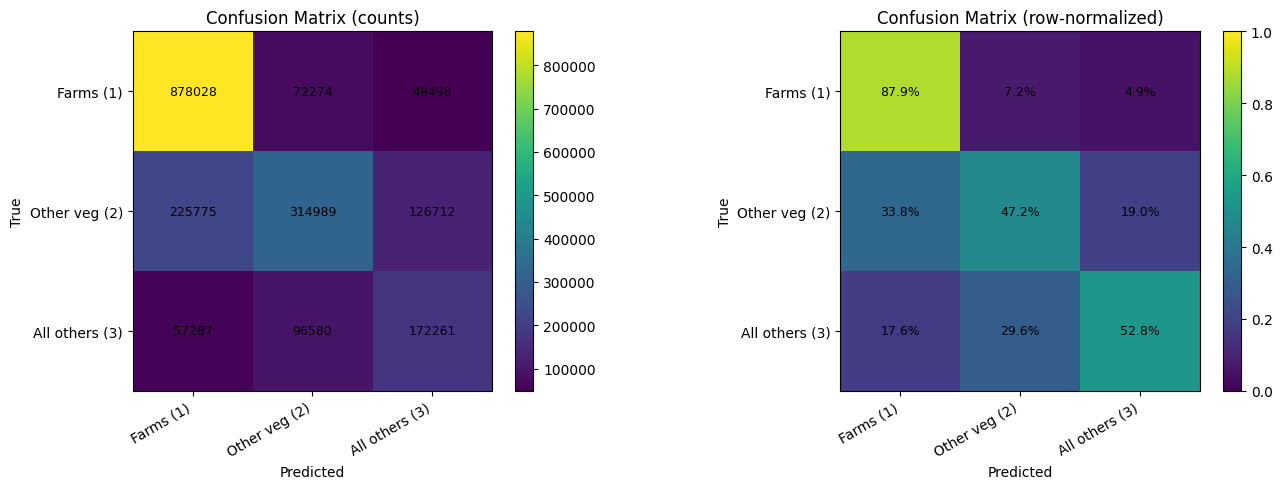

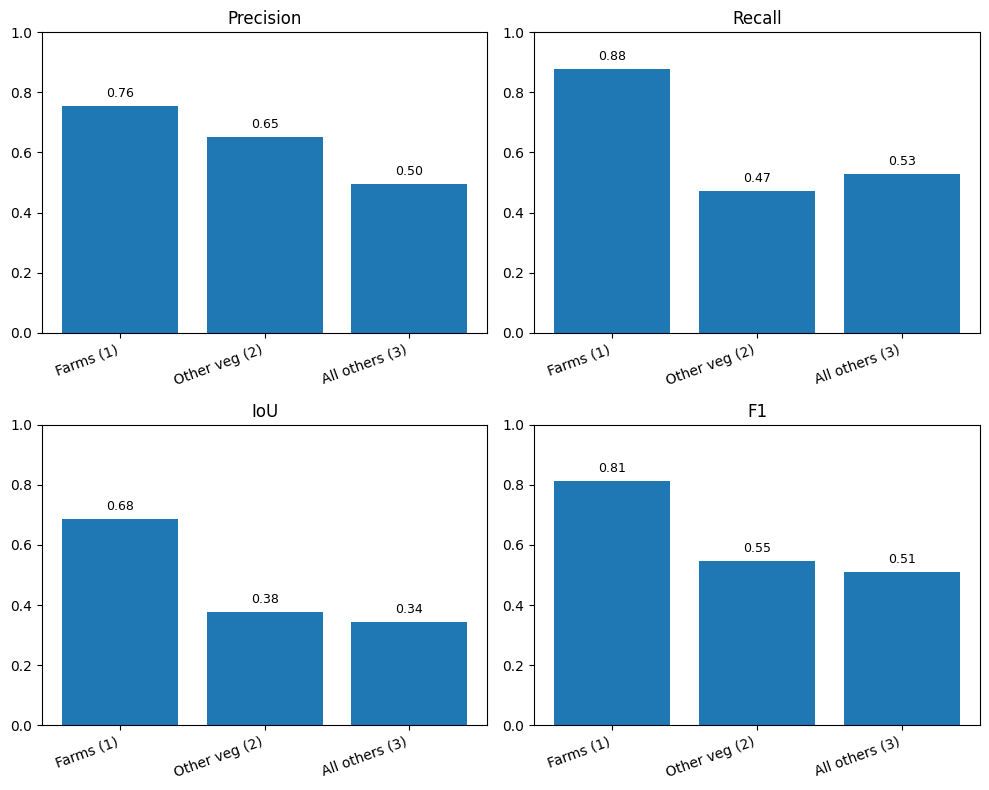

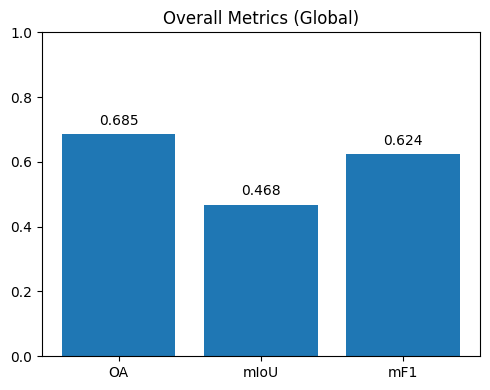

In [10]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

## patch_size = 512

### Model Creation

In [11]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 512,
    "stride": None,
    "num_epochs": 1,
    "ignore_index": 255,
    "num_classes": 3,

    # Model capacity
    "unet_depth": 4,
    "base_filters": 32,
    "use_batchnorm": True,
    "dropout_p": 0.0,

    # Optimizer / LR
    "optimizer": "adamw",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,

    # Loss & class imbalance
    "loss_type": "ce",
    "dice_alpha": 0.5,
    "focal_gamma": 2.0,
    "class_weights": "inv",
    "precomputed_counts": None,

    # Training tricks
    "accum_steps": 4,
    "use_amp": True,

    # Augmentations (applied per patch)
    "aug_strength": "none",

    # >>> NEW <<<
    "use_ndvi": True,              # set False to go RGB-only
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    # Accept None | np.ndarray | torch.Tensor
    if isinstance(class_weights, torch.Tensor):
        weight = class_weights  # already on device (ideally)
    elif class_weights is None:
        weight = None
    else:
        weight = torch.tensor(class_weights, dtype=torch.float32)  # CPU for now

    if loss_type == "ce":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        # ensure weight follows logits device at call time
        def ce_wrap(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return ce(logits, target)
        return ce_wrap

    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed

    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=weight)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")


# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    if strength == "none":
        return img_chw, lab_hw

    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1].copy()
        lab_hw  = lab_hw[:, ::-1].copy()
    if do_v:
        img_chw = img_chw[:, ::-1, :].copy()
        lab_hw  = lab_hw[::-1, :].copy()
    if krot:
        img_chw = np.rot90(img_chw, krot, axes=(-2,-1)).copy()
        lab_hw  = np.rot90(lab_hw,  krot, axes=(-2,-1)).copy()

    # final safety (ensures positive strides & contiguous)
    return np.ascontiguousarray(img_chw), np.ascontiguousarray(lab_hw)


# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    """
    img_hwcn: float32 array (H, W, C). May contain NaN in some channels (e.g., NDVI).
    We compute per-channel mean/std ignoring NaNs.
    """
    img = img_hwcn.astype(np.float32, copy=False)

    # Compute per-channel stats ignoring NaNs
    mean = np.nanmean(img, axis=(0, 1))
    std  = np.nanstd(img,  axis=(0, 1)) + 1e-6

    # Normalise where finite; keep NaNs for now
    img = (img - mean) / std

    # Replace any remaining non-finite with 0 (safe neutral value)
    img[~np.isfinite(img)] = 0.0

    # CHW tensor, contiguous float32
    return np.transpose(img, (2, 0, 1)).astype(np.float32, copy=False).copy()


### Training

In [12]:
rgb_folder_path     = Path("../data/train_rgb")                 # e.g. ../data/5m_rgb
ndvi_folder_path    = Path("../data/train_ndvi")             # NDVI tiles with ..._CIR_lrl.tif
label_train_folder  = Path("../data/lulc_tiles_train")

assert isinstance(train_rgb_tiles, list) and len(train_rgb_tiles) > 0, "train_rgb_tiles is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":
        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_rgb_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Helper: map RGB filename -> NDVI filename ----------
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    # fallback (case-insensitive)
    stem, ext = Path(rgb_name).stem, Path(rgb_name).suffix
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# (Optional) If you already have mapping dicts from your split step, you can use them:
# ndvi_by_rgb_train = {rgb: ndvi for rgb, ndvi in zip(train_rgb_tiles, train_ndvi_tiles)}  # if available

# ---------- Build model, optimizer, loss ----------
in_channels = 4 if CFG["use_ndvi"] else 3
model = UNetFlex(
    in_ch=in_channels,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# after you compute class_weights_vec
if class_weights_vec is not None:
    class_weights_t = torch.tensor(class_weights_vec, dtype=torch.float32, device=DEVICE)
else:
    class_weights_t = None

criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_t,   # pass a TENSOR already on DEVICE
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_rgb_tiles, start=1):
    print(f"{idx}/{len(train_rgb_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    # Resolve NDVI path if used
    if CFG["use_ndvi"]:
        # If you have ndvi_by_rgb_train dict, use: ndvi_name = ndvi_by_rgb_train.get(fname)
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping.")
            continue

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if CFG["use_ndvi"] else nullcontext(None)) as ndvi_src:

        # Grid checks (labels vs RGB)
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # read label once (RAM)
        label_full = lab_src.read(1)

        # Prepare NDVI reader aligned to RGB (only if used)
        if CFG["use_ndvi"]:
            need_vrt = (ndvi_src.crs != rgb_src.crs) or (ndvi_src.transform != rgb_src.transform) \
                       or (ndvi_src.width != rgb_src.width) or (ndvi_src.height != rgb_src.height)
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,  # continuous
                )
            else:
                ndvi_reader = ndvi_src

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch ----
                rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)  # (3,h,w)

               # ---- NDVI patch (optional) ----
                if CFG["use_ndvi"]:
                    # Read as masked to respect input nodata; keep as float32
                    ndvi_ma = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)  # MaskedArray (h, w)
                    ndvi_data = ndvi_ma.filled(np.nan)  # nodata -> NaN
                    # NDVI should live in [-1, 1]; clip outliers
                    ndvi_data = np.clip(ndvi_data, -1.0, 1.0)

                    # Stack with RGB
                    # (RGB comes as uint16; cast to float before stacking)
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)  # (3,h,w)
                    ndvi_patch = ndvi_data[np.newaxis, ...]  # (1,h,w)
                    img_patch = np.concatenate([rgb_patch, ndvi_patch], axis=0)  # (4,h,w)
                    img_hwcn  = np.transpose(img_patch, (1, 2, 0))               # (h,w,4)
                else:
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)
                    img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))               # (h,w,3)


                img_chw = normalize_img(img_hwcn)  # (C,H,W) where C = 3 or 4

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        if CFG["use_ndvi"] and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

Computing class counts for weights...
Class counts (1..C): [1556645, 2189268, 1117898]
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


### Testing

In [13]:
rgb_folder_path   = Path("../data/test_rgb")
ndvi_folder_path  = Path("../data/test_ndvi")
label_test_folder = Path("../data/lulc_tiles_test")

assert isinstance(test_rgb_tiles, list) and len(test_rgb_tiles) > 0, "test_rgb_tiles list is empty or undefined."
model.eval()

# --- Global confusion matrix ---
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

# --- Helper: map RGB → NDVI filename ---
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem = Path(rgb_name).stem
    ext  = Path(rgb_name).suffix
    i = stem.lower().find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# --- Tile evaluation ---
@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    # NDVI
    use_ndvi = bool(CFG.get("use_ndvi", False))
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping tile.")
            return

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if use_ndvi else nullcontext(None)) as ndvi_src:

        # --- Grid checks ---
        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata
        label_full = lab_src.read(1)

        # --- Align NDVI if needed ---
        if use_ndvi:
            need_vrt = (
                ndvi_src.crs != rgb_src.crs or
                ndvi_src.transform != rgb_src.transform or
                ndvi_src.width != rgb_src.width or
                ndvi_src.height != rgb_src.height
            )
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                )
            else:
                ndvi_reader = ndvi_src

        # --- Slide over patches ---
        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)

            # NDVI patch
            if use_ndvi:
                ndvi_ma   = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)
                ndvi_data = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)
                ndvi_ch   = ndvi_data[np.newaxis, ...]
                img_patch = np.concatenate([rgb_patch, ndvi_ch], axis=0)   # (4,h,w)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))             # (h,w,4)
            else:
                img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))             # (h,w,3)

            # Normalise
            img_chw = normalize_img(img_hwcn)

            # Label patch
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Confusion matrix update
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)

        if use_ndvi and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

# --- Run evaluation ---
total_tiles = len(test_rgb_tiles)
for i, fname in enumerate(test_rgb_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# --- Compute metrics ---
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE (RGB{}NDVI) ===".format("+" if CFG["use_ndvi"] else " "))
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 2/6: 2025_250000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 4/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 6/6: 2025_262000_470000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE (RGB+NDVI) ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.6845
Mean Accuracy (mAcc):  0.6446
Mean IoU (mIoU):       0.4843
Mean F1:               0.6403

Per-class results:
  Farms (1)        Precision: 0.8494  Recall: 0.7671  IoU: 0.6752  F1: 0.8061
  Other veg (2)    Precision: 0.5908  Recall: 0.6461  IoU: 0.4464  F1: 0.6172
  All others (3)   Precision: 0.4766  Recall: 0.5205  IoU: 0.3312  F1: 0.4976

Confusion Matrix (rows=true, cols=pred):
[[490113 112868  35966]
 [ 71457 290373  87608]
 [ 15443  88222 112537]]


### Performance Metrics (Plots)

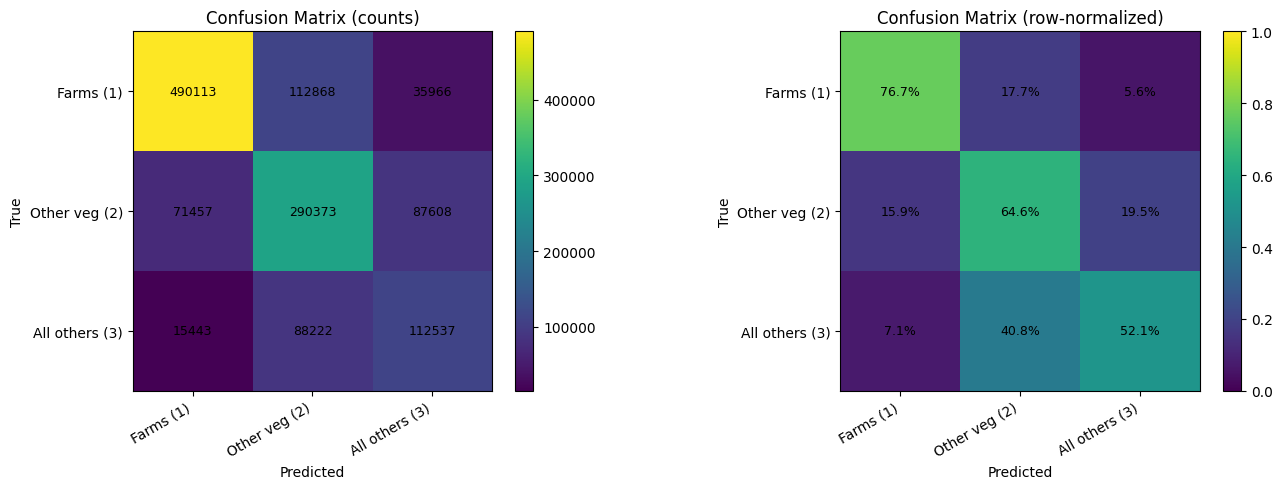

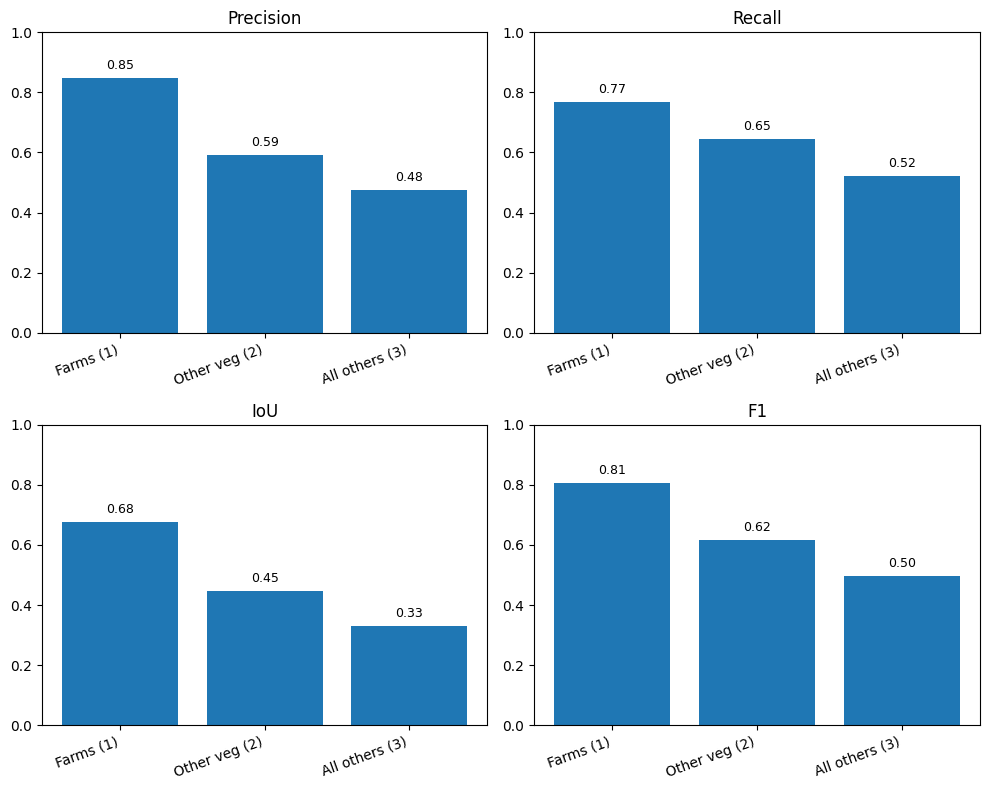

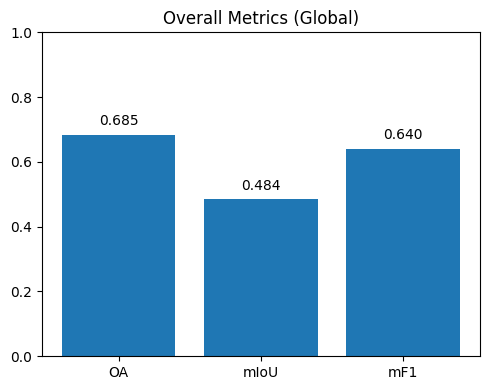

In [14]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

## patch_size = 768

### Model Creation

In [15]:
# =========================
# CONFIG for sensitivity runs
# =========================
CFG = {
    # Data / patching
    "patch_size": 768,
    "stride": None,
    "num_epochs": 1,
    "ignore_index": 255,
    "num_classes": 3,

    # Model capacity
    "unet_depth": 4,
    "base_filters": 32,
    "use_batchnorm": True,
    "dropout_p": 0.0,

    # Optimizer / LR
    "optimizer": "adamw",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,

    # Loss & class imbalance
    "loss_type": "ce",
    "dice_alpha": 0.5,
    "focal_gamma": 2.0,
    "class_weights": "inv",
    "precomputed_counts": None,

    # Training tricks
    "accum_steps": 4,
    "use_amp": True,

    # Augmentations (applied per patch)
    "aug_strength": "none",

    # >>> NEW <<<
    "use_ndvi": True,              # set False to go RGB-only
}

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SIZE   = CFG["patch_size"]
STRIDE       = (CFG["patch_size"] // 2) if CFG["stride"] is None else CFG["stride"]
NUM_EPOCHS   = CFG["num_epochs"]
IGNORE_INDEX = CFG["ignore_index"]
NUM_CLASSES  = CFG["num_classes"]
ACCUM_STEPS  = CFG["accum_steps"]
USE_AMP      = CFG["use_amp"]

# =========================
# UNet factory (variable depth/base, BN on/off, dropout)
# =========================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, use_bn=True, p_drop=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers.append(nn.Dropout2d(p_drop))

        layers2 = [
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        ]
        if use_bn: layers2.insert(1, nn.BatchNorm2d(out_ch))
        if p_drop > 0: layers2.append(nn.Dropout2d(p_drop))

        self.block = nn.Sequential(*layers, *layers2)

    def forward(self, x): return self.block(x)

class UNetFlex(nn.Module):
    """
    depth: number of encoding levels (>=3).
    base:  number of base filters.
    """
    def __init__(self, in_ch=3, n_classes=3, base=32, depth=4, use_bn=True, p_drop=0.0):
        super().__init__()
        assert depth >= 3, "UNet depth must be >= 3"
        self.depth = depth

        # Encoder
        encs = []
        chans = [base * (2**i) for i in range(depth)]
        encs.append(DoubleConv(in_ch, chans[0], use_bn, p_drop))
        for i in range(1, depth):
            encs.append(DoubleConv(chans[i-1], chans[i], use_bn, p_drop))
        self.encs = nn.ModuleList(encs)
        self.pools = nn.ModuleList([nn.MaxPool2d(2) for _ in range(depth-1)])

        # Decoder
        ups  = []
        decs = []
        for i in reversed(range(1, depth)):
            ups.append(nn.ConvTranspose2d(chans[i], chans[i-1], 2, stride=2))
            decs.append(DoubleConv(chans[i] , chans[i-1], use_bn, p_drop))  # concat doubles ch then conv back
        self.ups  = nn.ModuleList(ups)
        self.decs = nn.ModuleList(decs)

        self.out = nn.Conv2d(chans[0], n_classes, 1)

    def forward(self, x):
        feats = []
        z = x
        for i in range(self.depth):
            z = self.encs[i](z)
            feats.append(z)
            if i < self.depth-1:
                z = self.pools[i](z)
        # decode
        for j in range(self.depth-2, -1, -1):
            z = self.ups[self.depth-2 - j](z)
            z = torch.cat([z, feats[j]], dim=1)
            z = self.decs[self.depth-2 - j](z)
        return self.out(z)

# =========================
# Losses (CE, Dice, CE+Dice, Focal)
# =========================
class DiceLoss(nn.Module):
    def __init__(self, ignore_index=255, eps=1e-6):
        super().__init__()
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, logits, target):
        # logits: (N,C,H,W), target: (N,H,W) in {0..C-1 or ignore}
        N, C, H, W = logits.shape
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        target_valid = target.clone()
        target_valid[~valid] = 0

        probs = F.softmax(logits, dim=1)                       # (N,C,H,W)
        probs = probs.permute(0,2,3,1)[valid]                  # (V,C)
        target_oh = F.one_hot(target_valid[valid], num_classes=C).float()  # (V,C)

        inter = (probs * target_oh).sum(dim=0)                 # (C,)
        denom = probs.sum(dim=0) + target_oh.sum(dim=0)        # (C,)
        dice = (2*inter + self.eps) / (denom + self.eps)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, ignore_index=255, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.weight = weight

    def forward(self, logits, target):
        # mask ignore
        valid = (target != self.ignore_index)
        if not valid.any():
            return logits.new_zeros(())
        logits = logits.permute(0,2,3,1)[valid]   # (V,C)
        target = target[valid]                    # (V,)
        logpt = F.log_softmax(logits, dim=-1)
        pt = logpt.exp()
        # gather log prob of true class
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        loss = -(1-pt)**self.gamma * logpt
        if self.weight is not None:
            w = self.weight.to(logits.device)
            loss = loss * w[target]
        return loss.mean()

def make_loss(loss_type="ce", ignore_index=255, class_weights=None, dice_alpha=0.5, focal_gamma=2.0):
    # Accept None | np.ndarray | torch.Tensor
    if isinstance(class_weights, torch.Tensor):
        weight = class_weights  # already on device (ideally)
    elif class_weights is None:
        weight = None
    else:
        weight = torch.tensor(class_weights, dtype=torch.float32)  # CPU for now

    if loss_type == "ce":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        # ensure weight follows logits device at call time
        def ce_wrap(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return ce(logits, target)
        return ce_wrap

    elif loss_type == "ce_dice":
        ce = nn.CrossEntropyLoss(ignore_index=ignore_index, weight=weight)
        dice = DiceLoss(ignore_index=ignore_index)
        def mixed(logits, target):
            if ce.weight is not None and ce.weight.device != logits.device:
                ce.weight = ce.weight.to(logits.device)
            return (1 - dice_alpha) * ce(logits, target) + dice_alpha * dice(logits, target)
        return mixed

    elif loss_type == "focal":
        return FocalLoss(gamma=focal_gamma, ignore_index=ignore_index, weight=weight)

    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")


# =========================
# Simple paired augmentations
# =========================
rng = np.random.default_rng(42)

def augment_pair(img_chw, lab_hw, strength="none"):
    if strength == "none":
        return img_chw, lab_hw

    do_h = rng.random() < (0.5 if strength in ("light","medium") else 0.0)
    do_v = rng.random() < (0.2 if strength == "medium" else 0.0)
    krot = (rng.integers(0,4) if strength == "medium" else 0)

    if do_h:
        img_chw = img_chw[:, :, ::-1].copy()
        lab_hw  = lab_hw[:, ::-1].copy()
    if do_v:
        img_chw = img_chw[:, ::-1, :].copy()
        lab_hw  = lab_hw[::-1, :].copy()
    if krot:
        img_chw = np.rot90(img_chw, krot, axes=(-2,-1)).copy()
        lab_hw  = np.rot90(lab_hw,  krot, axes=(-2,-1)).copy()

    # final safety (ensures positive strides & contiguous)
    return np.ascontiguousarray(img_chw), np.ascontiguousarray(lab_hw)


# =========================
# Windowing & normalization
# =========================
def iter_windows_full(height, width, patch, stride):
    max_row = height - patch
    max_col = width  - patch
    if max_row < 0 or max_col < 0:
        return
    for row in range(0, max_row + 1, stride):
        for col in range(0, max_col + 1, stride):
            yield Window(col_off=col, row_off=row, width=patch, height=patch)

def normalize_img(img_hwcn):
    """
    img_hwcn: float32 array (H, W, C). May contain NaN in some channels (e.g., NDVI).
    We compute per-channel mean/std ignoring NaNs.
    """
    img = img_hwcn.astype(np.float32, copy=False)

    # Compute per-channel stats ignoring NaNs
    mean = np.nanmean(img, axis=(0, 1))
    std  = np.nanstd(img,  axis=(0, 1)) + 1e-6

    # Normalise where finite; keep NaNs for now
    img = (img - mean) / std

    # Replace any remaining non-finite with 0 (safe neutral value)
    img[~np.isfinite(img)] = 0.0

    # CHW tensor, contiguous float32
    return np.transpose(img, (2, 0, 1)).astype(np.float32, copy=False).copy()


### Training

In [16]:
rgb_folder_path     = Path("../data/train_rgb")                 # e.g. ../data/5m_rgb
ndvi_folder_path    = Path("../data/train_ndvi")             # NDVI tiles with ..._CIR_lrl.tif
label_train_folder  = Path("../data/lulc_tiles_train")

assert isinstance(train_rgb_tiles, list) and len(train_rgb_tiles) > 0, "train_rgb_tiles is empty or undefined."

# ---------- Compute class weights from training labels ----------
def compute_class_counts(tile_names, label_dir):
    counts = np.zeros(NUM_CLASSES, dtype=np.int64)  # for classes 1..NUM_CLASSES
    for fname in tile_names:
        p = label_dir / fname
        if not p.exists():
            continue
        with rasterio.open(p) as ds:
            lab = ds.read(1)
            for c in range(1, NUM_CLASSES+1):
                counts[c-1] += np.count_nonzero(lab == c)
    return counts

def calc_class_weights(mode, counts):
    if mode == "none" or counts is None:
        return None
    counts = counts.astype(np.float64) + 1e-6
    if mode == "inv":
        w = 1.0 / counts
    elif mode == "sqrt_inv":
        w = 1.0 / np.sqrt(counts)
    elif mode == "precomputed":
        pc = np.asarray(CFG["precomputed_counts"], dtype=np.float64) + 1e-6
        w = 1.0 / pc if CFG["class_weights"] == "inv" else 1.0 / np.sqrt(pc)
        return (w / w.mean()).astype(np.float32)
    else:
        return None
    return (w / w.mean()).astype(np.float32)

counts_for_weights = None
if CFG["class_weights"] in ("inv", "sqrt_inv"):
    print("Computing class counts for weights...")
    counts_for_weights = compute_class_counts(train_rgb_tiles, label_train_folder)
    print("Class counts (1..C):", counts_for_weights.tolist())

class_weights_vec = calc_class_weights(CFG["class_weights"], counts_for_weights)

# ---------- Helper: map RGB filename -> NDVI filename ----------
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    # fallback (case-insensitive)
    stem, ext = Path(rgb_name).stem, Path(rgb_name).suffix
    low = stem.lower()
    i = low.find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# (Optional) If you already have mapping dicts from your split step, you can use them:
# ndvi_by_rgb_train = {rgb: ndvi for rgb, ndvi in zip(train_rgb_tiles, train_ndvi_tiles)}  # if available

# ---------- Build model, optimizer, loss ----------
in_channels = 4 if CFG["use_ndvi"] else 3
model = UNetFlex(
    in_ch=in_channels,
    n_classes=NUM_CLASSES,
    base=CFG["base_filters"],
    depth=CFG["unet_depth"],
    use_bn=CFG["use_batchnorm"],
    p_drop=CFG["dropout_p"]
)

try:
    model = model.to(DEVICE)
except RuntimeError as e:
    if "out of memory" in str(e).lower() and torch.cuda.is_available():
        torch.cuda.empty_cache()
        DEVICE = "cpu"
        model = model.to(DEVICE)
    else:
        raise

# Optimizer
opt_name = CFG["optimizer"].lower()
if opt_name == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["learning_rate"], weight_decay=CFG["weight_decay"])

# after you compute class_weights_vec
if class_weights_vec is not None:
    class_weights_t = torch.tensor(class_weights_vec, dtype=torch.float32, device=DEVICE)
else:
    class_weights_t = None

criterion = make_loss(
    loss_type=CFG["loss_type"],
    ignore_index=IGNORE_INDEX,
    class_weights=class_weights_t,   # pass a TENSOR already on DEVICE
    dice_alpha=CFG["dice_alpha"],
    focal_gamma=CFG["focal_gamma"],
)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda" and USE_AMP))

# ---------- Train ----------
for idx, fname in enumerate(train_rgb_tiles, start=1):
    print(f"{idx}/{len(train_rgb_tiles)}", flush=True)

    rgb_path = rgb_folder_path / fname
    lab_path = label_train_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        continue

    # Resolve NDVI path if used
    if CFG["use_ndvi"]:
        # If you have ndvi_by_rgb_train dict, use: ndvi_name = ndvi_by_rgb_train.get(fname)
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping.")
            continue

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if CFG["use_ndvi"] else nullcontext(None)) as ndvi_src:

        # Grid checks (labels vs RGB)
        if rgb_src.crs != lab_src.crs:
            raise ValueError(f"CRS mismatch for {fname}: RGB {rgb_src.crs} vs LABEL {lab_src.crs}")
        if rgb_src.transform != lab_src.transform:
            raise ValueError(f"Transform mismatch for {fname}. Recreate label tiles to match RGB grid.")
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            raise ValueError(f"Size mismatch for {fname}. Recreate label tiles to match RGB size.")

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata

        # read label once (RAM)
        label_full = lab_src.read(1)

        # Prepare NDVI reader aligned to RGB (only if used)
        if CFG["use_ndvi"]:
            need_vrt = (ndvi_src.crs != rgb_src.crs) or (ndvi_src.transform != rgb_src.transform) \
                       or (ndvi_src.width != rgb_src.width) or (ndvi_src.height != rgb_src.height)
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,  # continuous
                )
            else:
                ndvi_reader = ndvi_src

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

            for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
                # ---- RGB patch ----
                rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16)  # (3,h,w)

               # ---- NDVI patch (optional) ----
                if CFG["use_ndvi"]:
                    # Read as masked to respect input nodata; keep as float32
                    ndvi_ma = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)  # MaskedArray (h, w)
                    ndvi_data = ndvi_ma.filled(np.nan)  # nodata -> NaN
                    # NDVI should live in [-1, 1]; clip outliers
                    ndvi_data = np.clip(ndvi_data, -1.0, 1.0)

                    # Stack with RGB
                    # (RGB comes as uint16; cast to float before stacking)
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)  # (3,h,w)
                    ndvi_patch = ndvi_data[np.newaxis, ...]  # (1,h,w)
                    img_patch = np.concatenate([rgb_patch, ndvi_patch], axis=0)  # (4,h,w)
                    img_hwcn  = np.transpose(img_patch, (1, 2, 0))               # (h,w,4)
                else:
                    rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)
                    img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))               # (h,w,3)


                img_chw = normalize_img(img_hwcn)  # (C,H,W) where C = 3 or 4

                # ---- Label patch from RAM ----
                r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
                lab_patch = label_full[r0:r0+h, c0:c0+w]

                # ---- Sanitize labels ----
                lab = lab_patch.astype(np.int64)
                if lab_nodata is not None:
                    lab[lab == lab_nodata] = IGNORE_INDEX
                invalid = (lab < 1) | (lab > NUM_CLASSES)
                lab[invalid] = IGNORE_INDEX
                valid = (lab != IGNORE_INDEX)
                if not np.any(valid):
                    continue
                lab[valid] -= 1  # 1..C -> 0..C-1

                # ---- Augment (paired) ----
                img_chw, lab = augment_pair(img_chw, lab, strength=CFG["aug_strength"])

                # ---- Tensors ----
                x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
                y = torch.from_numpy(lab).unsqueeze(0).to(DEVICE)

                # ---- Forward / loss / backward ----
                model.train()
                with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                    logits = model(x)
                    loss = criterion(logits, y) if callable(criterion) else criterion(logits, y)
                    loss = loss / ACCUM_STEPS

                scaler.scale(loss).backward()
                accum_count += 1

                if accum_count % ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    accum_count = 0

            # flush leftovers
            if accum_count > 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        if CFG["use_ndvi"] and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

Computing class counts for weights...
Class counts (1..C): [1556645, 2189268, 1117898]
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


### Testing

In [17]:
rgb_folder_path   = Path("../data/test_rgb")
ndvi_folder_path  = Path("../data/test_ndvi")
label_test_folder = Path("../data/lulc_tiles_test")

assert isinstance(test_rgb_tiles, list) and len(test_rgb_tiles) > 0, "test_rgb_tiles list is empty or undefined."
model.eval()

# --- Global confusion matrix ---
cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)

# --- Helper: map RGB → NDVI filename ---
def rgb_to_ndvi_name(rgb_name: str) -> str:
    if "_RGB_" in rgb_name:
        return rgb_name.replace("_RGB_", "_CIR_")
    stem = Path(rgb_name).stem
    ext  = Path(rgb_name).suffix
    i = stem.lower().find("rgb")
    if i != -1:
        return stem[:i] + "CIR" + stem[i+3:] + ext
    return rgb_name.replace("RGB", "CIR").replace("rgb", "CIR")

# --- Tile evaluation ---
@torch.no_grad()
def evaluate_one_tile(fname):
    global cm

    rgb_path = rgb_folder_path / fname
    lab_path = label_test_folder / fname
    if not rgb_path.exists() or not lab_path.exists():
        print(f"Missing pair for {fname}, skipping.")
        return

    # NDVI
    use_ndvi = bool(CFG.get("use_ndvi", False))
    if use_ndvi:
        ndvi_name = rgb_to_ndvi_name(fname)
        ndvi_path = ndvi_folder_path / ndvi_name
        if not ndvi_path.exists():
            print(f"[WARN] NDVI missing for {fname} -> expected {ndvi_path.name}; skipping tile.")
            return

    with rasterio.open(rgb_path) as rgb_src, \
         rasterio.open(lab_path) as lab_src, \
         (rasterio.open(ndvi_path) if use_ndvi else nullcontext(None)) as ndvi_src:

        # --- Grid checks ---
        if rgb_src.crs != lab_src.crs or rgb_src.transform != lab_src.transform:
            print(f"Grid mismatch for {fname}, skipping.")
            return
        if (rgb_src.width != lab_src.width) or (rgb_src.height != lab_src.height):
            print(f"Size mismatch for {fname}, skipping.")
            return

        H, W = rgb_src.height, rgb_src.width
        lab_nodata = lab_src.nodata
        label_full = lab_src.read(1)

        # --- Align NDVI if needed ---
        if use_ndvi:
            need_vrt = (
                ndvi_src.crs != rgb_src.crs or
                ndvi_src.transform != rgb_src.transform or
                ndvi_src.width != rgb_src.width or
                ndvi_src.height != rgb_src.height
            )
            if need_vrt:
                ndvi_reader = WarpedVRT(
                    ndvi_src,
                    crs=rgb_src.crs,
                    transform=rgb_src.transform,
                    width=rgb_src.width,
                    height=rgb_src.height,
                    resampling=Resampling.bilinear,
                )
            else:
                ndvi_reader = ndvi_src

        # --- Slide over patches ---
        for win in iter_windows_full(H, W, PATCH_SIZE, STRIDE):
            # RGB patch
            rgb_patch = rgb_src.read([1, 2, 3], window=win, out_dtype=np.uint16).astype(np.float32)

            # NDVI patch
            if use_ndvi:
                ndvi_ma   = ndvi_reader.read(1, window=win, masked=True).astype(np.float32)
                ndvi_data = np.clip(ndvi_ma.filled(np.nan), -1.0, 1.0)
                ndvi_ch   = ndvi_data[np.newaxis, ...]
                img_patch = np.concatenate([rgb_patch, ndvi_ch], axis=0)   # (4,h,w)
                img_hwcn  = np.transpose(img_patch, (1, 2, 0))             # (h,w,4)
            else:
                img_hwcn  = np.transpose(rgb_patch, (1, 2, 0))             # (h,w,3)

            # Normalise
            img_chw = normalize_img(img_hwcn)

            # Label patch
            r0, c0, h, w = int(win.row_off), int(win.col_off), int(win.height), int(win.width)
            lab_patch = label_full[r0:r0+h, c0:c0+w]
            lab = lab_patch.astype(np.int64)
            if lab_nodata is not None:
                lab[lab == lab_nodata] = IGNORE_INDEX
            invalid = (lab < 1) | (lab > NUM_CLASSES)
            lab[invalid] = IGNORE_INDEX
            valid = (lab != IGNORE_INDEX)
            if not np.any(valid):
                continue
            lab[valid] -= 1

            # Predict
            x = torch.from_numpy(img_chw).unsqueeze(0).to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda" and USE_AMP)):
                logits = model(x)
                pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

            # Confusion matrix update
            t = lab[valid].ravel()
            p = pred[valid].ravel()
            idx = t * NUM_CLASSES + p
            binc = np.bincount(idx, minlength=NUM_CLASSES**2)
            cm += binc.reshape(NUM_CLASSES, NUM_CLASSES)

        if use_ndvi and ndvi_reader is not ndvi_src:
            ndvi_reader.close()

# --- Run evaluation ---
total_tiles = len(test_rgb_tiles)
for i, fname in enumerate(test_rgb_tiles, start=1):
    print(f"Evaluating tile {i}/{total_tiles}: {fname}", flush=True)
    evaluate_one_tile(fname)

# --- Compute metrics ---
tp = np.diag(cm).astype(float)
total = cm.sum()

if total == 0:
    print("\nNo valid pixels evaluated.")
    precision = recall = iou = f1 = np.zeros(NUM_CLASSES, dtype=float)
    oa = mean_acc = mean_iou = mean_f1 = 0.0
else:
    oa = tp.sum() / total
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp

    recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn) != 0)
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp) != 0)
    iou       = np.divide(tp, tp + fp + fn, out=np.zeros_like(tp), where=(tp+fp+fn) != 0)
    f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(tp), where=(precision+recall)!=0)

    mean_acc  = float(np.mean(recall))
    mean_iou  = float(np.mean(iou))
    mean_f1   = float(np.mean(f1))

class_names = ["Farms (1)", "Other veg (2)", "All others (3)"]

print("\n=== GLOBAL TEST PERFORMANCE (RGB{}NDVI) ===".format("+" if CFG["use_ndvi"] else " "))
print(f"Total tiles evaluated: {total_tiles}")
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Mean Accuracy (mAcc):  {mean_acc:.4f}")
print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print(f"Mean F1:               {mean_f1:.4f}")

print("\nPer-class results:")
for name, p, r, j, f in zip(class_names, precision, recall, iou, f1):
    print(f"  {name:15s}  Precision: {p:.4f}  Recall: {r:.4f}  IoU: {j:.4f}  F1: {f:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm)

metrics_cm = cm.copy()
metrics_per_class = {
    "precision": precision.copy(),
    "recall":    recall.copy(),
    "iou":       iou.copy(),
    "f1":        f1.copy(),
    "class_names": class_names[:],
}
metrics_overall = {
    "oa": oa, "mAcc": mean_acc, "mIoU": mean_iou, "mF1": mean_f1,
    "total_tiles": total_tiles, "total_pixels": int(total),
}

Evaluating tile 1/6: 2025_246000_470000_RGB_lrl.tif
Evaluating tile 2/6: 2025_250000_466000_RGB_lrl.tif
Evaluating tile 3/6: 2025_258000_466000_RGB_lrl.tif
Evaluating tile 4/6: 2025_258000_470000_RGB_lrl.tif
Evaluating tile 5/6: 2025_258000_482000_RGB_lrl.tif
Evaluating tile 6/6: 2025_262000_470000_RGB_lrl.tif

=== GLOBAL TEST PERFORMANCE (RGB+NDVI) ===
Total tiles evaluated: 6
Overall Accuracy (OA): 0.5263
Mean Accuracy (mAcc):  0.3947
Mean IoU (mIoU):       0.2302
Mean F1:               0.3352

Per-class results:
  Farms (1)        Precision: 0.5090  Recall: 0.9935  IoU: 0.5073  F1: 0.6731
  Other veg (2)    Precision: 0.7502  Recall: 0.1291  IoU: 0.1238  F1: 0.2203
  All others (3)   Precision: 0.6522  Recall: 0.0613  IoU: 0.0594  F1: 0.1121

Confusion Matrix (rows=true, cols=pred):
[[364975   2375      9]
 [241652  36448   4181]
 [110449   9760   7856]]


### Performance Metrics (Plots)

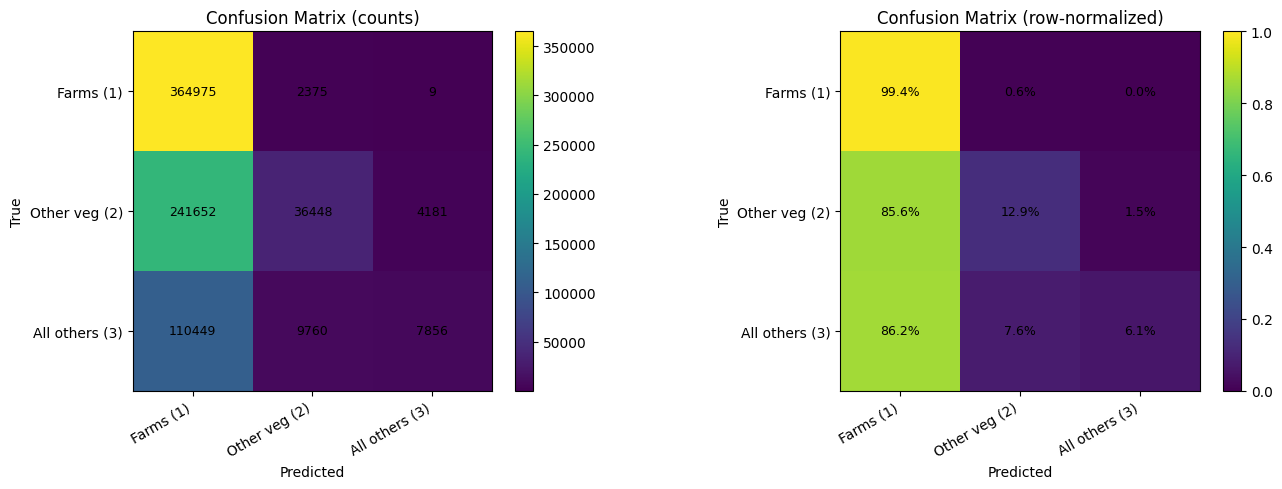

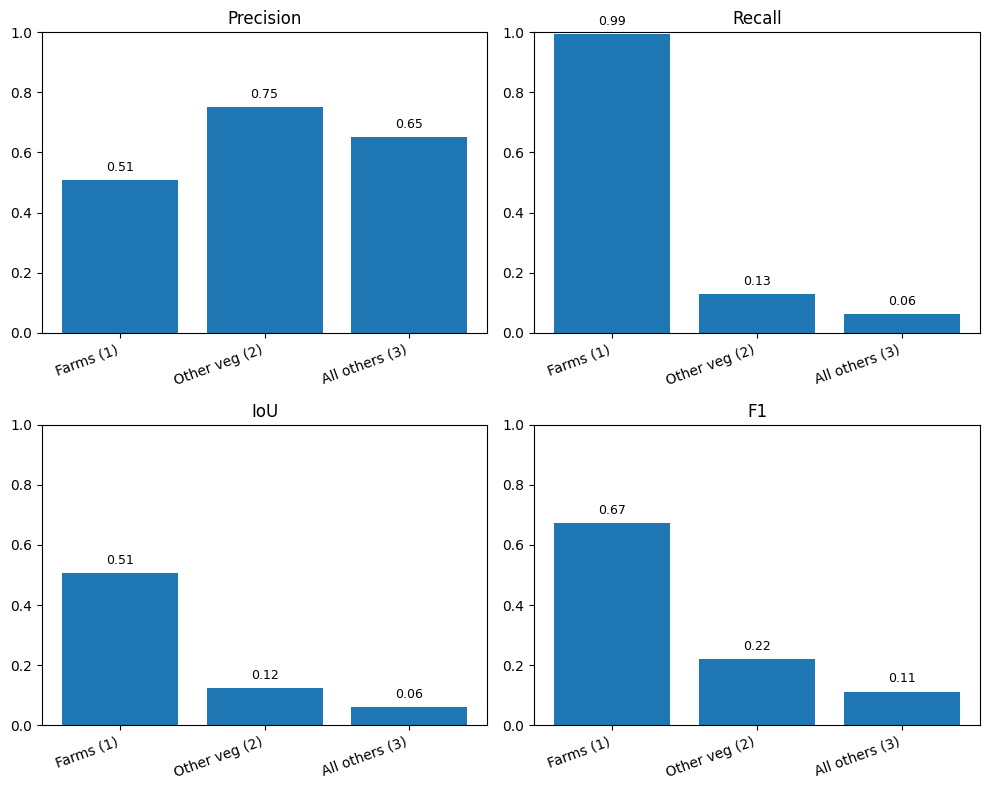

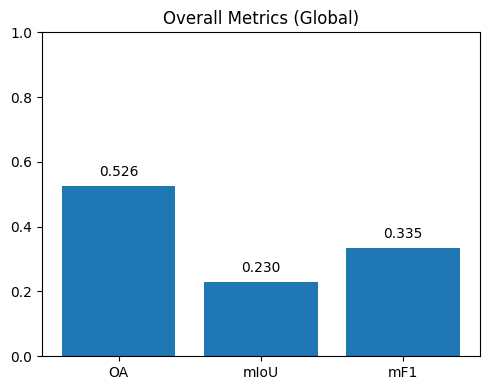

In [18]:
cm = metrics_cm
per = metrics_per_class
ov  = metrics_overall
class_names = per["class_names"]

# --- 1) Confusion matrix heatmap (counts + normalized) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(len(class_names))); ax[0].set_yticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=30, ha='right')
ax[0].set_yticklabels(class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# row-normalized (%)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums!=0)
im1 = ax[1].imshow(norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion Matrix (row-normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(class_names))); ax[1].set_yticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=30, ha='right')
ax[1].set_yticklabels(class_names)
for i in range(norm.shape[0]):
    for j in range(norm.shape[1]):
        ax[1].text(j, i, f"{norm[i, j]*100:.1f}%", ha="center", va="center", fontsize=9)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 2) Four bar plots: Precision, Recall, IoU, F1 ---
metrics_list = [("Precision", per["precision"]),
                ("Recall",    per["recall"]),
                ("IoU",       per["iou"]),
                ("F1",        per["f1"])]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for k, (title, vals) in enumerate(metrics_list):
    axs[k].bar(range(len(class_names)), vals)
    axs[k].set_title(title)
    axs[k].set_ylim(0, 1)
    axs[k].set_xticks(range(len(class_names)))
    axs[k].set_xticklabels(class_names, rotation=20, ha='right')
    for i, v in enumerate(vals):
        axs[k].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Overall metrics bar plot: OA, mIoU, mF1 ---
overall_names = ["OA", "mIoU", "mF1"]
overall_vals  = [ov["oa"], ov["mIoU"], ov["mF1"]]

plt.figure(figsize=(5,4))
plt.bar(range(len(overall_names)), overall_vals)
plt.xticks(range(len(overall_names)), overall_names)
plt.ylim(0, 1)
for i, v in enumerate(overall_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.title("Overall Metrics (Global)")
plt.tight_layout()
plt.show()

# Summary

Among the different patch sizes tested, the 512×512 configuration achieved the strongest overall performance, with an overall accuracy (OA) of 0.68, a mean F1 of 0.64, and a mean IoU of 0.48. The 256×256 patches performed comparably but slightly lower (mF1 = 0.62, mIoU = 0.47), while 128×128 patches showed weaker accuracy and overlap (mF1 = 0.54, mIoU = 0.38). At the other extreme, 768×768 patches led to a drastic performance drop (mF1 = 0.33, mIoU = 0.23), indicating poor generalisation and class imbalance. The 512-pixel patches thus provided the most stable and accurate segmentation across all classes, balancing fine detail and contextual information effectively.

These results can be explained by the trade-off between spatial context and sample diversity. Small patches (128) capture fine details but lose broader spatial context, leading to noisy predictions and fragmented class boundaries. Extremely large patches (768) limit the number of training samples and reduce the model’s exposure to diverse patterns, causing overfitting to dominant textures. The mid-sized patches (256–512) strike an optimal balance: they provide enough context for meaningful spatial relationships while maintaining sufficient training variability.

Based on this analysis, patch_size = 512 was selected for subsequent experiments. It yielded the best mean IoU and mean F1 scores, demonstrating improved class discrimination and spatial consistency. This size effectively leverages both local and contextual cues, making it well-suited for 5 m resolution tiles where each patch still represents meaningful land-cover structures.